# データの作成

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

num = 10000

categories = ["保険","食品","銀行","印刷","農林","水産","通信"]
products = ["製品A","製品B","製品C","製品D","製品E","製品F"]
np.random.seed(1)
df1 = pd.DataFrame({
    "key":np.arange(num),
    "営業部署":[np.random.choice(["営業1部","営業2部","営業3部"]) for i in range(num)],
    "営業課":[np.random.choice(["営業A課","営業B課","営業C課"]) for i in range(num)],
    "顧客分類":[np.random.choice(categories) for i in range(num)],
    "製品名":[np.random.choice(products) for i in range(num)],
    "金額":np.random.poisson(10000,num)    
})
df2 = df1.copy()
df2["金額"] = df2["金額"].mask((df2["営業部署"] == "営業3部") & (df2["営業課"] == "営業B課"), -100)
df2 = df2[~((df2["営業部署"]=="営業1部") & (df2["営業課"]=="営業A課") & (df2["key"] < 100))]
df2 = df2[["key","金額"]]

In [2]:
df1

,key,営業部署,営業課,顧客分類,製品名,金額
0,0,営業2部,営業A課,印刷,製品B,10027
1,1,営業1部,営業A課,水産,製品A,10017
2,2,営業1部,営業B課,保険,製品A,10061
3,3,営業2部,営業B課,水産,製品C,9942
4,4,営業2部,営業C課,銀行,製品F,9962
...,...,...,...,...,...,...
9995,9995,営業1部,営業B課,通信,製品A,10176
9996,9996,営業1部,営業C課,農林,製品D,9933
9997,9997,営業2部,営業C課,水産,製品D,9898
9998,9998,営業1部,営業A課,通信,製品D,9963


In [3]:
df2

,key,金額
0,0,10027
2,2,10061
3,3,9942
4,4,9962
5,5,10032
...,...,...
9995,9995,10176
9996,9996,9933
9997,9997,9898
9998,9998,9963


データの差異の発見

In [4]:
df_merge = pd.merge(df1,df2,on="key",how="left")
df_merge["diff"] = ~(df_merge["金額_x"] == df_merge["金額_y"])
df_merge.groupby(["営業部署","営業課"],as_index=False)["diff"].sum()

,営業部署,営業課,diff
0,営業1部,営業A課,10
1,営業1部,営業B課,0
2,営業1部,営業C課,0
3,営業2部,営業A課,0
4,営業2部,営業B課,0
5,営業2部,営業C課,0
6,営業3部,営業A課,0
7,営業3部,営業B課,1099
8,営業3部,営業C課,0


# 要因差異の発見

## 1.決定木に使用する変数の決定

In [5]:
columns = ["営業部署","営業課","顧客分類","製品名","diff","金額_x"]
df_train = df_merge[columns].copy()

## 2.カテゴリ変数の数値化

In [6]:
df_train = pd.get_dummies(df_train)
df_train

,diff,金額_x,営業部署_営業1部,営業部署_営業2部,営業部署_営業3部,営業課_営業A課,営業課_営業B課,営業課_営業C課,顧客分類_保険,顧客分類_印刷,...,顧客分類_農林,顧客分類_通信,顧客分類_銀行,顧客分類_食品,製品名_製品A,製品名_製品B,製品名_製品C,製品名_製品D,製品名_製品E,製品名_製品F
0,False,10027,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,True,10017,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,False,10061,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,False,9942,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,False,9962,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,10176,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
9996,False,9933,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
9997,False,9898,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9998,False,9963,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


## 3.決定木の適用

In [7]:
from sklearn import tree
X = df_train.drop("diff",1)
y = df_train["diff"]
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X,y)

## 4.精度の確認

In [8]:
df_train["pred"] = clf.predict(X)
pd.crosstab(df_train["diff"],df_train["pred"])

pred,False,True
diff,,
False,8891,0
True,10,1099


## 5.要因の探索

[Text(334.8, 570.7800000000001, '営業課_営業B課 <= 0.5\ngini = 0.197\nsamples = 10000\nvalue = [8891, 1109]\nclass = diff無'),
 Text(167.4, 407.70000000000005, '営業部署_営業1部 <= 0.5\ngini = 0.003\nsamples = 6727\nvalue = [6717, 10]\nclass = diff無'),
 Text(83.7, 244.62, 'gini = 0.0\nsamples = 4536\nvalue = [4536, 0]\nclass = diff無'),
 Text(251.10000000000002, 244.62, '営業課_営業C課 <= 0.5\ngini = 0.009\nsamples = 2191\nvalue = [2181, 10]\nclass = diff無'),
 Text(167.4, 81.53999999999996, 'gini = 0.018\nsamples = 1106\nvalue = [1096, 10]\nclass = diff無'),
 Text(334.8, 81.53999999999996, 'gini = 0.0\nsamples = 1085\nvalue = [1085, 0]\nclass = diff無'),
 Text(502.20000000000005, 407.70000000000005, '営業部署_営業3部 <= 0.5\ngini = 0.446\nsamples = 3273\nvalue = [2174, 1099]\nclass = diff無'),
 Text(418.5, 244.62, 'gini = 0.0\nsamples = 2174\nvalue = [2174, 0]\nclass = diff無'),
 Text(585.9, 244.62, 'gini = 0.0\nsamples = 1099\nvalue = [0, 1099]\nclass = diff有')]

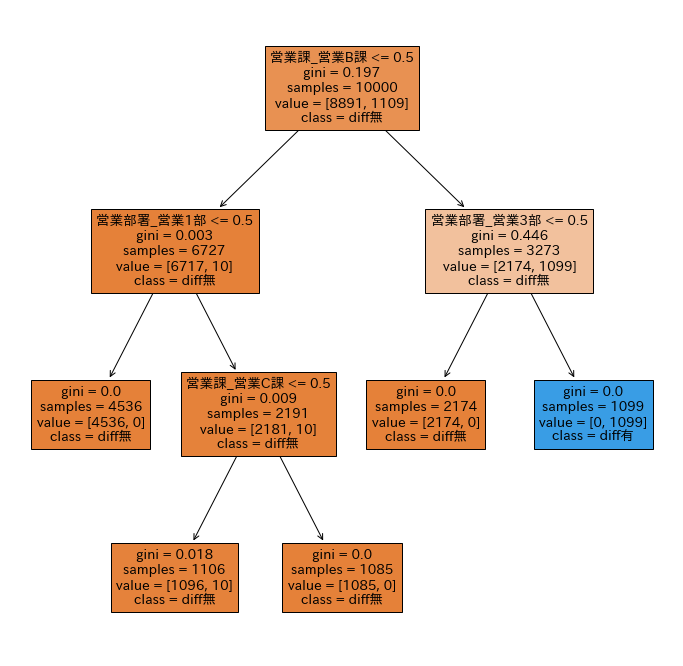

In [9]:
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.figure(figsize=(12,12))
tree.plot_tree(clf,feature_names=X.columns,class_names=["diff無","diff有"], filled=True)